# Lesson 27: Hacker statistics

(c) 2017 Justin Bois. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

*This tutorial was generated from a Jupyter notebook.  You can download the notebook [here](l27_hackerstats.ipynb).*

In [1]:
import numpy as np

# Plotting modules and settings.
import matplotlib.pyplot as plt
import seaborn as sns
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
          '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
          '#bcbd22', '#17becf']
sns.set(style='whitegrid', palette=colors, rc={'axes.labelsize': 16})

# The following is specific Jupyter notebooks
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}


When the field of statistics was in its early days, the practitioners did not have computers. They were therefore left to use pen and paper to compute things like confidence intervals. With just a little bit of programming experience, you can perform lots of the statistical analyses that may seem baffling when done with pencil and paper.

At the heart of this "hacker statistics" is the ability to draw random numbers. We will focus on **bootstrap** methods in particular.

To motivate this study, we will work with data measured by Peter and Rosemary Grant on the island of Daphne Major on the Galápagos. They have been going to the island every year for over forty years and have been taking a careful inventory of the finches there. We will look at the finch *Geospiza scandens*. The Grants measured the depths of the beaks (defined as the top-to-bottom thickness of the beak) of all of the finches of this species on the island. We will consider their measurements from 1975 and from 2012. We will investigate how the beaks got deeper over time.

The data are from the book Grants' book *40 years of evolution: Darwin's finches on Daphne Major Island*](http://www.worldcat.org/oclc/854285415). They were generous and made their data publicly available on the [Dryad data repository](http://dx.doi.org/10.5061/dryad.g6g3h). In general, it is a very good idea to put your published data in public data repositories, both to preserve the data and also to make your findings public.

Ok, let's start by loading in the data. The beak depths are stored in the files `~/git/data/beak_depth_scandens_1975.csv` and `~/git/data/beak_depth_scandens_2012.csv`.

In [2]:
bd_1975 = np.loadtxt('data/beak_depth_scandens_1975.csv')
bd_2012 = np.loadtxt('data/beak_depth_scandens_2012.csv')

We'll use the `ecdf()` function you wrote yesterday to generate the ECDFs so we can plot them. I'll define it here so we have it going forward.

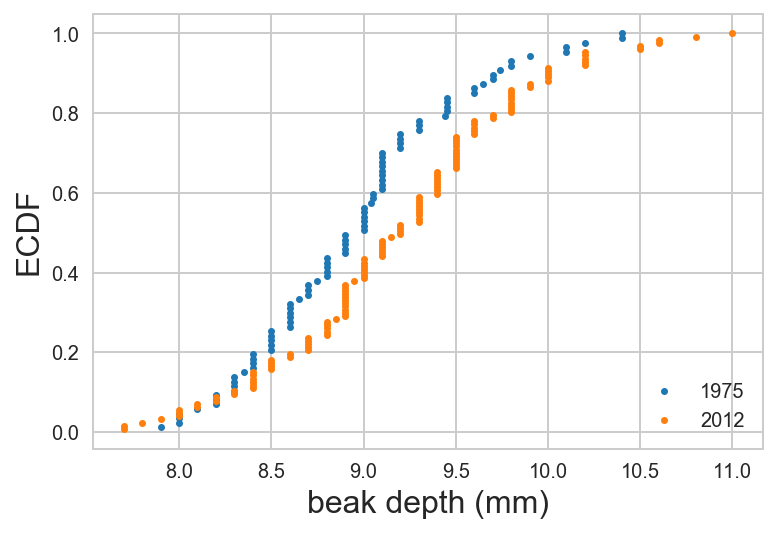

In [3]:
def ecdf(data):
    """Generate x and y values for plotting an ECDF."""
    return np.sort(data), np.arange(1, len(data)+1) / len(data)

# Compute ECDFs for 1975 and 2012
x_1975, y_1975 = ecdf(bd_1975)
x_2012, y_2012 = ecdf(bd_2012)

# Plot the ECDFs
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('beak depth (mm)')
ax.set_ylabel('ECDF')
_ = ax.plot(x_1975, y_1975, marker='.', linestyle='none')
_ = ax.plot(x_2012, y_2012, marker='.', linestyle='none')
ax.legend(('1975', '2012'), loc='lower right');

Judging from the ECDFs, it seems as though beaks have gotten deeper over time. But now, we would like a *statistic* to compare. One statistic that comes to mind it the mean. So, let's compare those.

In [4]:
np.mean(bd_1975), np.mean(bd_2012)

(8.9599999999999991, 9.1862204724409455)

So, indeed, the mean beak depth is bigger in 2012 than in 1975. There is clearly some variability in beak depth among the birds measured each year, so it is possible that this observation is just due to random chance and the mean beak depth is really not that big. So, we would like to compute a *confidence interval* of the mean. We will compute the 95% confidence interval.

What is a 95% confidence interval? It can be thought of as follows. If we were to repeat the experiment over and over and over again, 95% of the time, the observed mean would lie in the 95% confidence interval. So, if the confidence intervals of the means of measurements from 1975 and from 2012 overlapped, we might not be so sure that the beaks got deeper due to some underlying selective pressure, but that we just happened *observed* deeper beaks as a result of natural variability.

So, how do we compute a confidence interval? ....We use our computer!

## Bootstrap confidence intervals

The notion of the bootstrap was first published by Brad Efron in 1979. The idea is simple, and we will take the fact that it works as a given; Efron proved it for us. 

Here's the idea: If we could somehow repeat the measurements of the beak depths on Daphne Major, we could do it many many times, and we could then just compute the 2.5th and 97.5th percentiles to get a 95% confidence interval. The problem is, we can't repeat the experiments over and over again. 1975 only happened once, and all birds on the island were measured. We cannot have 1975 happen again under exactly the same conditions. 

Instead, we will have our computer *simulate* doing the experiment over and over again. Hacker statistics! We have one set of measurements. We "repeat" the experiment by drawing measurements out of the ones we have again and again. Here's what we do to compute a bootstrap estimate of the mean of a set of $n$ data points.
>1. Draw $n$ data points out of the original data set *with replacement*. This set of data points is called a **bootstrap sample**.
2. Compute the mean of the bootstrap sample. This is called a **bootstrap replicate** of the mean.
3. Do this over and over again, storing the results.

So, it is as if we did the experiment over and over again, obtaining a mean each time. Remember, our bootstrap sample has exactly the same number of "measurements" as the original data set. Let's try it with the `bd_1975` data (remember the mean beak depth was 8.96 mm). First we'll generate a bootstrap sample. Remember, the function `np.random.choice()` allows us to sample out of an array with replacement, if we like.

In [5]:
np.random.seed(42)
bs_sample = np.random.choice(bd_1975, replace=True, size=len(bd_1975))

Let's take a quick look at this bootstrap sample by plotting its ECDF right next to that of the original data set.

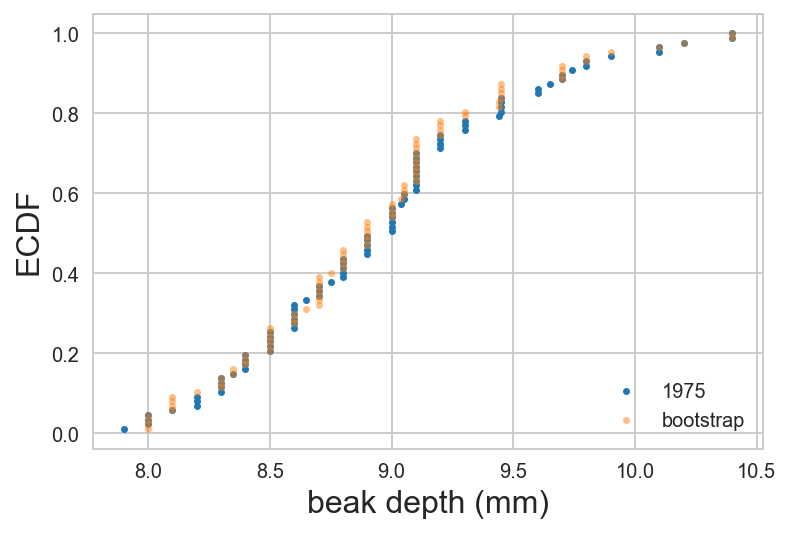

In [6]:
# Compute ECDF of bootstrap sample
x_bs, y_bs = ecdf(bs_sample)

# Plot the ECDFs
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('beak depth (mm)')
ax.set_ylabel('ECDF')
_ = ax.plot(x_1975, y_1975, marker='.', linestyle='none')
_ = ax.plot(x_bs, y_bs, marker='.', linestyle='none', alpha=0.5)
ax.legend(('1975', 'bootstrap'), loc='lower right');

It is qualitatively similar, but obviously not exactly the same data set.

Now, let's compute our bootstrap replicate. It's as simple as computing the mean of the bootstrap sample.

In [7]:
bs_replicate = np.mean(bs_sample)
bs_replicate

8.9260919540229899

So, the mean of the bootstrap replicate is 8.93 mm, which is less than the mean of 8.96 from the original data set.

Now, we can write a **`for`** loop to get lots and lots of bootstrap replicas.

In [8]:
# Number of replicas
n_reps = 100000

# Initialize bootstrap replicas array
bs_reps_1975 = np.empty(n_reps)

# Compute replicates
for i in range(n_reps):
    bs_sample = np.random.choice(bd_1975, size=len(bd_1975))
    bs_reps_1975[i] = np.mean(bs_sample)

Now that we have our replicas, 100,000 of them, we can plot an ECDF to see what we might expect of the mean if we were to do the experiment again.

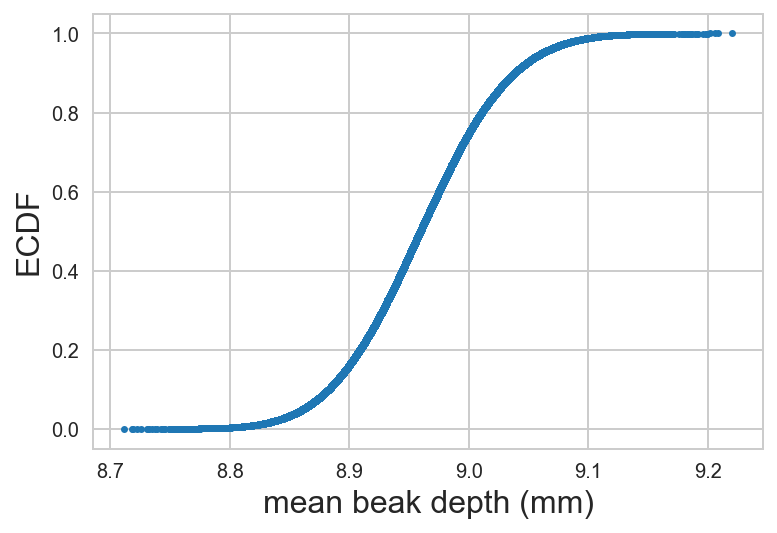

In [9]:
# Compute ECDF
x, y = ecdf(bs_reps_1975)

# Plot the ECDF
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('mean beak depth (mm)')
ax.set_ylabel('ECDF')
_ = plt.plot(x, y, marker='.', linestyle='none')

It looks Normally distributed, and in fact it must be Normally distributed by the Central Limit Theorem (which we will not discuss here, but we didn't really need to derive; hacker statistics brought us here!). The most probable mean (located at the inflection point on the CDF) we would get is 8.96 mm, which was what was measured, but upon repeating the experiment, we could get a mean as low as about 8.7 mm or as high as about 9.2 mm.

Let's compute the 95% confidence interval.

In [10]:
conf_int_1975 = np.percentile(bs_reps_1975, [2.5, 97.5])
conf_int_1975

array([ 8.84298851,  9.08103448])

### Aside: list comprehensions

The construction we had for making our bootstrap replicates was a bit clunky:

    # Initialize bootstrap replicas array
    bs_reps_1975 = np.empty(n_reps)

    # Compute replicates
    for i in range(n_reps):
        bs_sample = np.random.choice(bd_1975, size=len(bd_1975))
        bs_reps_1975[i] = np.mean(bs_sample)
 
 We had to set up an empty array, and then loop through each index, draw a bootstrap sample, compute its mean to get the replicate, and then place it in the array. We could, instead, write a function to compute a bootstrap replicate from data.

In [11]:
def bs_replicate(data, func=np.mean):
    """Compute a bootstrap replicate from data."""
    bs_sample = np.random.choice(data, size=len(data))
    return func(bs_sample)

Note that this function is generic in that it can compute the replicate using any function, such as `np.median()`, `np.std()`, or anything else. With this function in hand, our code starts to look a little cleaner.

    # Initialize bootstrap replicas array
    bs_reps_1975 = np.empty(n_reps)

    # Compute replicates
    for i in range(n_reps):
        bs_reps_1975 = bs_replicate(bd_1975, func=np.mean)

We still have the problem that we initialize the array and then do the **`for`** loop. Python offers us a very useful alternative to this kind of procedure of initializing and array and the looping over it: **list comprehensions**. This, as usual, is best seen by example.

In [12]:
bs_reps_1975 = [bs_replicate(bd_1975, func=np.mean) for _ in range(n_reps)]

To use a list comprehension to make a list, you enclose the expression in brackets. The first item in the brackets is what you want to put at each element of the list you are creating. Next, you use a **`for`** keyword to set up the iteration over the elements of the list. In our case, the index of the element does not matter; we just want to compute `n_reps` replicates, so we do not need to keep track of the index.

The result is a list, so we might want to convert it to a Numpy array.

In [13]:
bs_reps_1975 = np.array([bs_replicate(bd_1975, func=np.mean) for _ in range(n_reps)])

This is must more concise and perhaps cleaner syntax.

Just to show how values of an iterator can be passed for each element, here is how you can make a list of the first 10 cubes.

In [14]:
[i**3 for i in range(1, 11)]

[1, 8, 27, 64, 125, 216, 343, 512, 729, 1000]

Great! Now let's use a list comprehension to make bootstrap replicates for the 2012 samples.

In [15]:
# Compute replicates
bs_reps_2012 = np.array([bs_replicate(bd_2012, func=np.mean) for _ in range(n_reps)])
    
# Compute the confidence interval
conf_int_2012 = np.percentile(bs_reps_2012, [2.5, 97.5])

Now, let's print the two confidence intervals next to each other for comparison.

In [16]:
print(conf_int_1975)
print(conf_int_2012)

[ 8.84298851  9.08103448]
[ 9.07125984  9.3015748 ]


So, the 95% confidence intervals for the 2012 and 1975 juuust overlap. This implies that the inherent variation in beak depths is likely not responsible for the observed difference. There was likely some selective pressure toward deeper beaks.

## Equivalence of bootstrap samples and standard error of the mean

The **standard error of the mean**, or SEM, is a measure of uncertainty of the estimate of the mean. In other words, if we did the set of measurements again, we would get a different mean. The variability in these measured means is described by the SEM. Specifically, it is the standard deviation of the Normal distribution describing the mean of repeated measurements. So, from bootcamp replicates, we can directly apply this formula.

In [17]:
bs_sem = np.std(bs_reps_1975)
bs_sem

0.060493114594221874

It can be shown analytically that the SEM can be computed directly from the measurements as the standard deviation of the measurements divided by the square root of the number of measurements.

In [18]:
sem = np.std(bd_1975, ddof=1) / np.sqrt(len(bd_1975))
sem

0.060745392196298008

Hey, we got the same result! Bootstrap replicates are easy to generate in general for any statistic, and the error on those statistics might not be as simple as for the mean.

## Bootstrap confidence interval of the standard deviation

We are not limited to computing bootstrap confidence intervals of the mean. We could compute bootstrap confidence intervals of any statistic, like the median, standard deviation, the mean divided by the standard deviation, whatever we like. Computing the confidence interval for the standard deviation is the same procedure as we have done; we just put `np.std` in for `np.mean`.

[ 0.47722948  0.63870044]


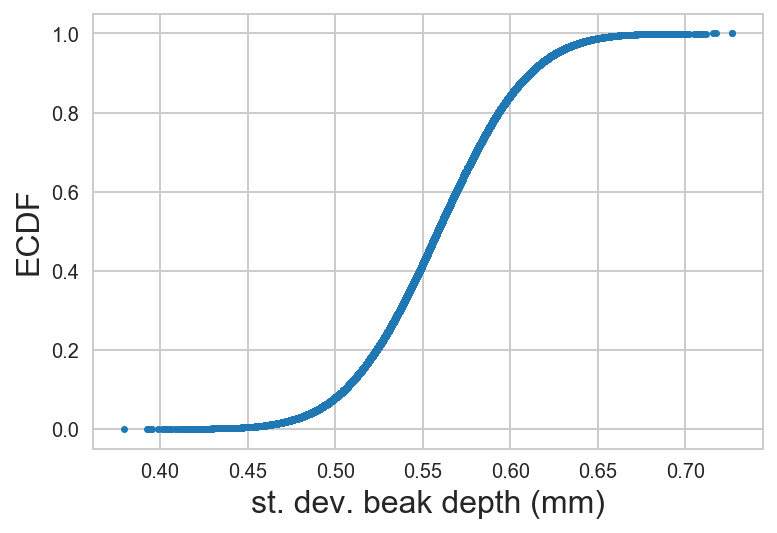

In [19]:
# Compute replicates
bs_reps_1975 = np.array([bs_replicate(bd_1975, func=np.std) for _ in range(n_reps)])
    
# Compute confidence interval
conf_int_1975 = np.percentile(bs_reps_1975, [2.5, 97.5])
print(conf_int_1975)

# Compute ECDF
x, y = ecdf(bs_reps_1975)

# Plot the ECDF
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('st. dev. beak depth (mm)')
ax.set_ylabel('ECDF')
_ = plt.plot(x, y, marker='.', linestyle='none')

So, we now also have an estimate for the variability in beak depth. It could range from about 0.48 to 0.64 mm.